In [31]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [32]:
import numpy as np
import pandas as pd

In [33]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [34]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [35]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [36]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [37]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [38]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [39]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [40]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
max_date = session.query(func.max(Measurement.date))
min_date = session.query(func.min(Measurement.date))
print(max_date[0])
print(min_date[0])
# Calculate the date 1 year ago from the last data point in the database
expression = '%Y-%m-%d'
max_date = dt.datetime.strptime(max_date[0][0], expression)
one_year_data = dt.timedelta(days=365)
one_year_ago_data = max_date - one_year_data
print(one_year_ago_data.strftime(expression))



('2017-08-23',)
('2010-01-01',)
2016-08-23


,date,precipitation
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02


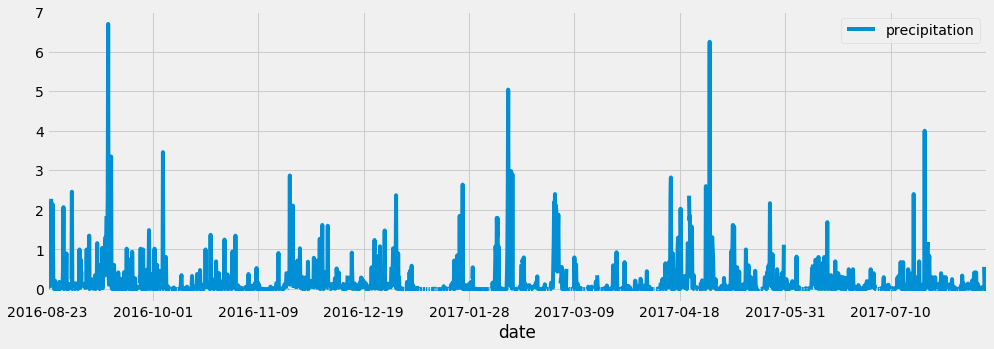

In [41]:
# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago_data.strftime(expression)).filter(Measurement.date <= max_date.strftime(expression)).order_by(Measurement.date)
# Save the query results as a Pandas DataFrame and set the index to the date column
dataFrame = pd.DataFrame(query,columns=['date','precipitation'])
# Sort the dataframe by date
dataFrame.set_index('date')
# Use Pandas Plotting with Matplotlib to plot the data
dataFrame.plot(x='date', figsize = (15, 5))
dataFrame.head()

![precipitation](Images/precipitation.png)

In [42]:
# Use Pandas to calcualte the summary statistics for the precipitation data
dataFrame.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [43]:
# Design a query to show how many stations are available in this dataset?
print(session.query(func.count(Station.station)).all()[0][0])
session.query(Station.station).all()

9


[('USC00519397'),
 ('USC00513117'),
 ('USC00514830'),
 ('USC00517948'),
 ('USC00518838'),
 ('USC00519523'),
 ('USC00519281'),
 ('USC00511918'),
 ('USC00516128')]

In [44]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station,func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

most_active = session.query(Measurement.station,func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()

print (active_stations)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [45]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temp = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station == most_active.station).first()

print (temp)

(54.0, 85.0, 71.66378066378067)


USC00519281


,temperature
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0


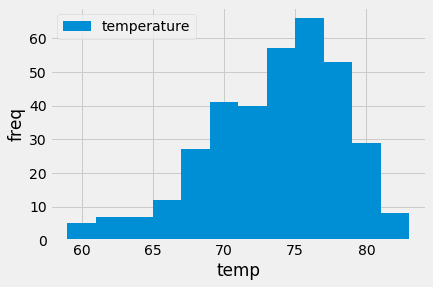

In [52]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
#station_temp = session.query(func.count(Measurement.tobs), Measurement.station)\
#.group_by(Measurement.station)\
#.order_by(func.count(Measurement.tobs).desc()).first

#station_temp2 = session.query(Measurement.tobs).filter(Measurement.date >= one_year_ago_data.strftime(expression))\
#.filter(Measurement.date <= max_date.strftime(expression))\
#.filter(Measurement.station == station_temp.station)\
#.order_by(Measurement.date)

#dataframe = pd.DataFrame(station_temp2, columns = ['temperature'])

#plot = df.plot(kind='hist', bins=10)
#plot.set_xlabel('temp')
#plot.set_ylabel('Freq')

#dataframe.head()

station_temp2 = session.query(func.count(Measurement.tobs),Measurement.station).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).first()
print (station_temp2.station)

station_temps2 = session.query(Measurement.tobs).filter(Measurement.date >= one_year_ago_data.strftime(expression)).\
filter(Measurement.date <= max_date.strftime(expression)).\
filter(Measurement.station == station_temp2.station).order_by(Measurement.date)

df = pd.DataFrame(station_temps2,columns=['temperature'])



plot = df.plot(kind="hist",bins=12)
plot.set_xlabel("temp")
plot.set_ylabel("freq")

df.head()

![precipitation](Images/station-histogram.png)

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temp = calc_temps(one_year_ago_data.strftime(expression), max_date.strftime(expression))
print(temp)

[(58.0, 74.59058295964125, 87.0)]


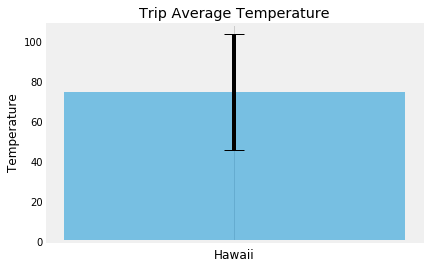

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
average = temp[0][1]
error = temp[0][2] - temp[0][0]

fig, ax = plt.subplots()
ax.bar("", average, yerr=error, align = 'center', alpha =0.5, ecolor='black', capsize=10)
ax.set_xlabel('Hawaii')
ax.set_ylabel('Temperature')
ax.set_title('Trip Average Temperature')
ax.yaxis.grid(False)
plt.show()

In [26]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
total = session.query(Measurement.station, func.sum(Measurement.prcp), Station.name, Station.latitude, Station.longitude, Station.elevation)\
.filter(Measurement.date >= one_year_ago_data.strftime(expression))\
.filter(Measurement.date <= max_date.strftime(expression))\
.filter(Measurement.station == Station.station)\
.group_by(Measurement.station)\
.order_by(func.sum(Measurement.prcp).desc()).all()

for row in total:
    print(row)

('USC00516128', 147.81000000000006, 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)
('USC00519281', 70.03000000000003, 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)
('USC00513117', 48.510000000000026, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
('USC00519523', 38.01, 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)
('USC00514830', 33.239999999999995, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)
('USC00519397', 16.089999999999986, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
('USC00517948', 4.59, 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


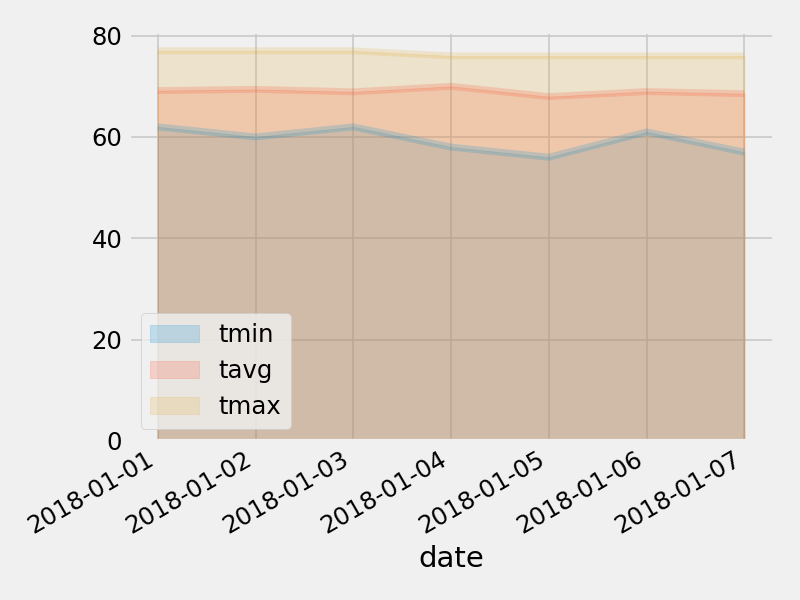

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
